C:\Users\PIPI\AppData\Local\Temp\ipykernel_25928\1978451273.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, interval="5m", period="60d")
[*********************100%***********************]  1 of 1 completed
C:\Users\PIPI\AppData\Local\Temp\ipykernel_25928\1978451273.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close       = float(df['Close'].iloc[i])
C:\Users\PIPI\AppData\Local\Temp\ipykernel_25928\1978451273.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prev_close  = float(df['Close'].iloc[i-1])


Total PnL (points): -1029.0
Number of trades: 298
Win rate: 34.9 %


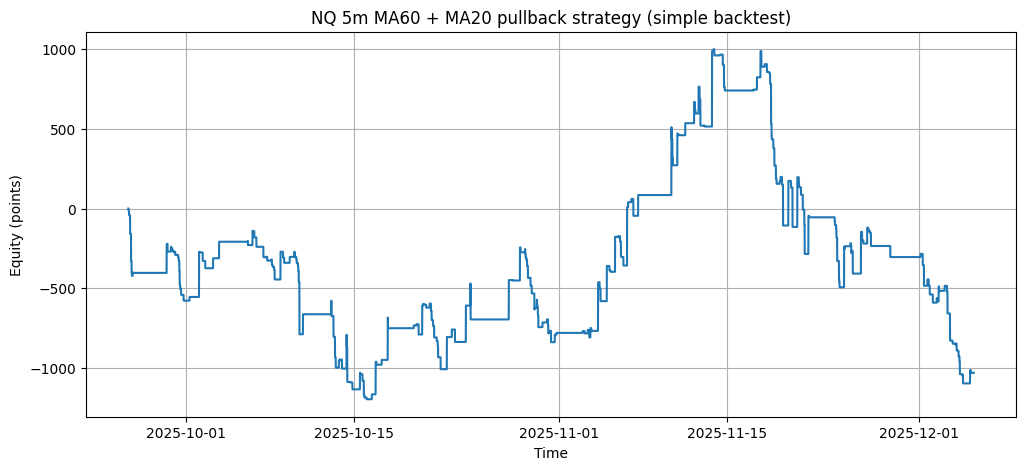

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 抓 NQ 5 分鐘資料
symbol = "NQ=F"   # 用 NQ 當 MNQ 的代理
data = yf.download(symbol, interval="5m", period="60d")
df = data[['Open','High','Low','Close','Volume']].copy()
df.dropna(inplace=True)

# 2. 計算 MA20 / MA60 與 60MA 斜率
df['ma20'] = df['Close'].rolling(20).mean()
df['ma60'] = df['Close'].rolling(60).mean()
df['ma60_slope'] = df['ma60'] - df['ma60'].shift(5)

# 3. 超簡單回測
position = 0          # 1 = 多, -1 = 空, 0 = 空手
entry_price = 0.0
equity = 0.0          # 用點數當作權益單位
equity_curve = []
trade_pnls = []

for i in range(60, len(df)):
    # 這裡通通強制轉成 float，保證不是 Series
    close       = float(df['Close'].iloc[i])
    prev_close  = float(df['Close'].iloc[i-1])
    ma20_prev   = float(df['ma20'].iloc[i-1])
    slope       = float(df['ma60_slope'].iloc[i])

    # 記錄目前權益
    equity_curve.append(equity)

    # MA 還沒算好就跳過
    if np.isnan(slope) or np.isnan(ma20_prev):
        continue

    # ===== 已有部位：先處理出場 =====
    if position == 1:
        # 多單：60MA 斜率變成往下 → 出場
        if slope < 0:
            pnl = close - entry_price
            equity += pnl
            trade_pnls.append(pnl)
            position = 0
        continue    # 這根K棒就不再開新倉

    if position == -1:
        # 空單：60MA 斜率變成往上 → 出場
        if slope > 0:
            pnl = entry_price - close
            equity += pnl
            trade_pnls.append(pnl)
            position = 0
        continue

    # ===== 沒部位：才考慮進場 =====
    # 價格是否貼近 ma20（回檔）
    near_ma20 = abs(prev_close - ma20_prev) / prev_close < 0.005  # 直接是 True/False

    # 多頭進場：斜率往上 + 回到 ma20 + K棒往上
    if slope > 0 and near_ma20 and (close > prev_close):
        position = 1
        entry_price = close

    # 空頭進場：斜率往下 + 回到 ma20 + K棒往下
    elif slope < 0 and near_ma20 and (close < prev_close):
        position = -1
        entry_price = close

# 把 equity_curve 填滿
while len(equity_curve) < len(df):
    equity_curve.append(equity)
df['equity'] = equity_curve

print("Total PnL (points):", equity)
print("Number of trades:", len(trade_pnls))
if trade_pnls:
    win_rate = sum(1 for p in trade_pnls if p > 0) / len(trade_pnls)
    print("Win rate:", round(win_rate*100, 2), "%")

# 4. 畫資金曲線
plt.figure(figsize=(12,5))
plt.plot(df.index, df['equity'])
plt.title("NQ 5m MA60 + MA20 pullback strategy (simple backtest)")
plt.xlabel("Time")
plt.ylabel("Equity (points)")
plt.grid(True)
plt.show()
